In [245]:
from scipy import signal as ss
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [246]:
data = {'fp': [1000], 'fa': [1900], 'Ap': [1], 'Aa': [30], 'fs':[10000]}
df = pd.DataFrame.from_dict(data)
df.head()

,fp,fa,Ap,Aa,fs
0,1000,1900,1,30,10000


In [247]:
def sos_table(sos):
    a2 = sos[:,:3][:,2]
    a1 = sos[:,:3][:,1]
    a0 = sos[:,:3][:,0]
    b2 = sos[:,3:][:,2]
    b1 = sos[:,3:][:,1]
    b0 = sos[:,3:][:,0]
    data_sos = {'A2': a2, 'A1': a1, 'A0': a0, 'B2': b2, 'B1': b1, 'B0': b0}
    df_sos = pd.DataFrame.from_dict(data_sos)
    return df_sos

In [248]:
def plot_s_singularities(zeros, poles):
    plt.subplot(1,2,1)
    x_z = zeros.real
    y_z = zeros.imag
    x_p = poles.real
    y_p = poles.imag
    plt.scatter(x_z, y_z, marker='o', color='blue')
    plt.scatter(x_p, y_p, marker='x',color='red')
    plt.axis('square')
    xl, xr = plt.xlim()
    yu, yb = plt.ylim()
    max_len = abs(xl-xr) if abs(xl-xr)>abs(yu-yb) else abs(yu-yb)
    plt.xlim((-0.9*max_len, max_len*0.1))
    plt.grid()

In [249]:
def plot_mag(filtz, filts):
    wz, hz = ss.freqz_zpk(filtz.zeros, filtz.poles, filtz.gain)
    ws, hs = ss.freqs_zpk(filts.zeros, filts.poles, filts.gain, worN=10000*wz)
    plt.plot(wz/(2*np.pi), 20*np.log10(np.abs(hz).clip(1e-15)), label=r'$|H_a(j \omega)|$')
    plt.plot(wz/(2*np.pi), 20*np.log10(np.abs(hs).clip(1e-15)), label=r'$|H_d(e^{j \omega})|$')
    plt.legend()
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude [dB]')
    plt.grid()

Utilizando la aproximacion de Butterworth la funcion que se obtiene para el campo analógico es de la formma
$$ H(s) = \frac{1}{\sum_{i=0}^{N}b_i \cdot s^i} $$
Utilizadno la tranformacion bilineal $s = \frac{z-1}{z+1} $ se obtiene 
$$ H(z) = \frac{1}{\sum_{i=0}^{N}b_i \cdot \left(\frac{z-1}{z+1}\right) ^i} $$
Multiplicando numerador y denominador por $(z+1)^N$ se obtiene
$$ H(z) = \frac{(z+1)^N}{\sum_{i=0}^{N}b_i \cdot (z-1)^i \cdot (z+1)^{N-i} } $$
De lo cual se puede observar que se obtiene N ceros en Z=-1, singularidades que en el dominio analógico se ubican en le infinito.

In [250]:
""" Busco el orden del filtro Analógico """
N, ws = ss.buttord(2*np.pi*1000, 2*np.pi*1900, 1, 30, analog=True)

In [251]:
""" Funcion tranferencia Analógica """
z, p, k = ss.butter(N, ws, 'low', True, output='zpk')
filt_s = ss.lti(z, p, k)
""" Paso al campo digital con la transformacion Bilineal """
zz, pz, kz= ss.bilinear_zpk(z, p, k, 10000)
filt_z = ss.lti(zz, pz, kz)

In [252]:
sos = ss.zpk2sos(zz, pz, kz, pairing='keep_odd')

In [253]:
sos_table(sos)

,A2,A1,A0,B2,B1,B0
0,0.0,0.000128,0.000128,0.000000,-0.485893,1.0
1,1.0,2.000000,1.000000,0.284686,-1.009989,1.0
2,1.0,2.000000,1.000000,0.443712,-1.135012,1.0
3,1.0,2.000000,1.000000,0.758213,-1.382265,1.0


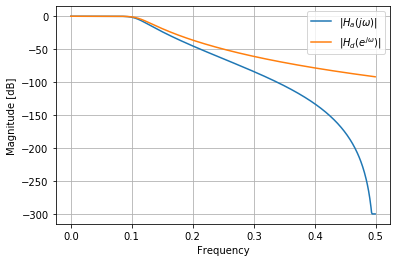

In [254]:
plot_mag(filt_z, filt_s)

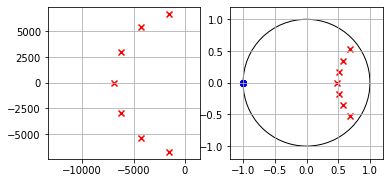

In [255]:
plot_s_singularities(z, p)
plot_singularities(zz, pz)

Sintetizando nuevametne el filtro pero ahora utilizando la aproximacion de Cauer

In [256]:
""" Busco el orden del filtro Analógico """
N_c, ws_c = ss.ellipord(2*np.pi*1000, 2*np.pi*1900, 1, 30, analog=True)

In [257]:
""" Funcion tranferencia Analógica """
z_c, p_c, k_c = ss.ellip(N_c, 1, 30, ws_c, 'low', True, output='zpk')
filt_s_c = ss.lti(z_c, p_c, k_c)
""" Paso al campo digital con la transformacion Bilineal """
zz_c, pz_c, kz_c= ss.bilinear_zpk(z_c, p_c, k_c, 10000)
filt_z_c = ss.lti(zz_c, pz_c, kz_c)

In [258]:
""" Separo las singularidades del filtro digital """
sos_c = ss.zpk2sos(zz_c, pz_c, kz_c, pairing='keep_odd')

In [259]:
sos_table(sos_c)

,A2,A1,A0,B2,B1,B0
0,0.0,0.044588,0.044588,0.000000,-0.700978,1.0
1,1.0,-0.905664,1.000000,0.790153,-1.463796,1.0


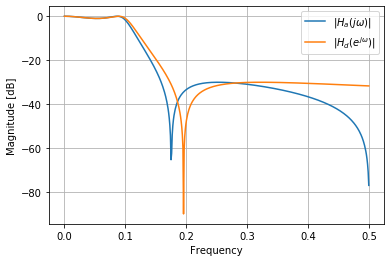

In [260]:
plot_mag(filt_z_c, filt_s_c)

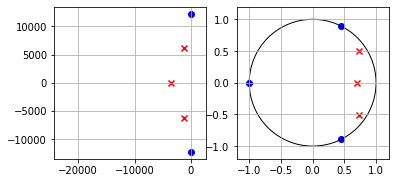

In [261]:
plot_s_singularities(z_c, p_c)
plot_singularities(zz_c, pz_c)

Del diagrama de las singularidades se puede apreciar como los ceros del eje jw son mapeados a la circunferecnia de radio 1, y los ceros en el infinito son mapeados en Z=-1, al igual que se pudo apreciar en la aproximacion de Butterworth. Luego los polos del semiplano izquierdo se puede apreciar que son mapeados dentro de la circunferecnia de radio 1.